<a href="https://colab.research.google.com/github/sobhanshukueian/Style-Transfer/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

Higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but do not constrain the exact pixel values of the reconstruction.
In contrast, reconstructions from the lower layers simply reproduce the exact pixel values of the original image. We, therefore, refer to the feature responses in higher layers of the network as the content representation.
To obtain a representation of the style of an input image, we use a feature space originally designed to capture texture information. This feature space is built on top of the filter responses in each layer of the network. It consists of the correl.ations between the different filter responses over the spatial extent of the feature maps.


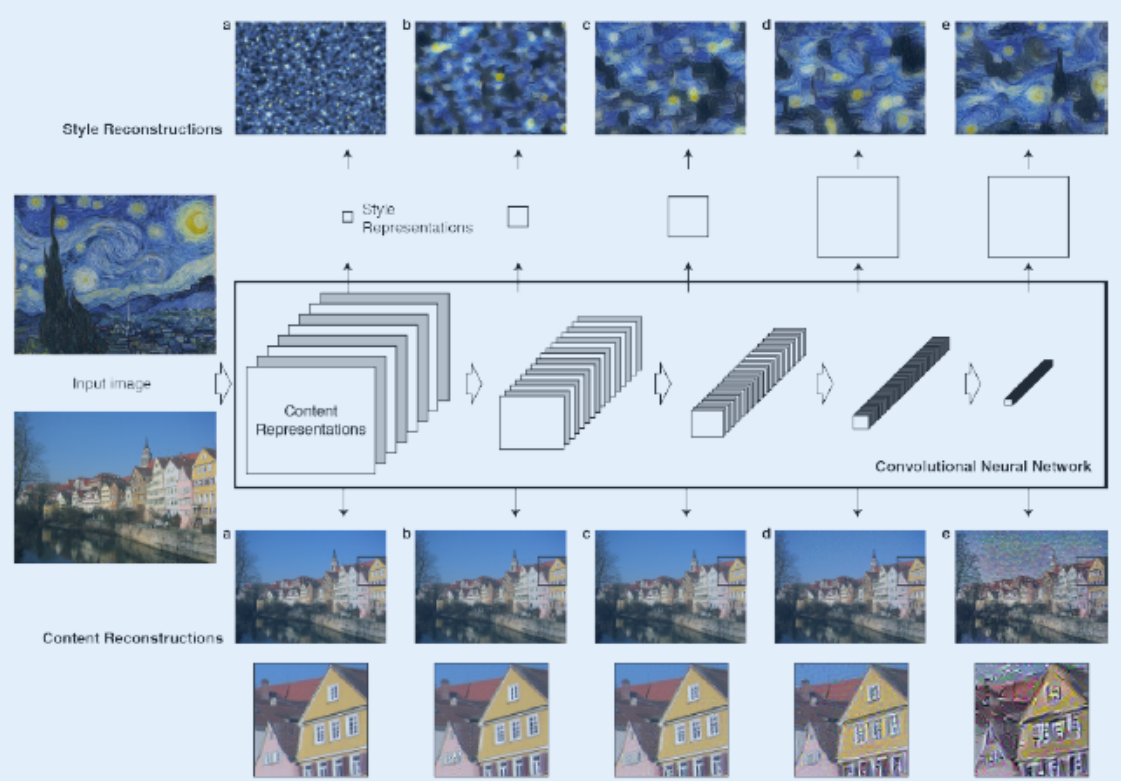

[Paper Link](https://arxiv.org/abs/1508.06576)

In [ ]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [ ]:
model=models.vgg19(pretrained=True).features
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # conv blocks
        self.req_features= ['0','5','10','19','28'] 
        self.model=models.vgg19(pretrained=True).features[:29] 
    
    def forward(self, x):
        features=[]
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if (str(layer_num) in self.req_features):
                features.append(x)
        return features

In [ ]:
def image_load(path, device):
    image=Image.open(path).convert('RGB')
    loader=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor()])
    image=loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
#@title Define image's path 

org_image = "/content/sobhan.jpg"#@param
style_image = '/content/style Image2.jpg' #@param

original_image=image_load(org_image, 0)
style_image=image_load(style_image, 0)
generated_image=original_image.clone().requires_grad_(True)


In [ ]:
#@title Plot Images

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Original Image")
ax[0].imshow(torch.squeeze(original_image).permute(1, 2, 0).cpu().numpy())
ax[1].set_title("Style Image")
ax[1].imshow(torch.squeeze(style_image).permute(1, 2, 0).cpu().numpy()) 
plt.show()

# Loss

## Content Loss

This is based on the intuition that images with similar content will have similar representation in the higher layers of the network.

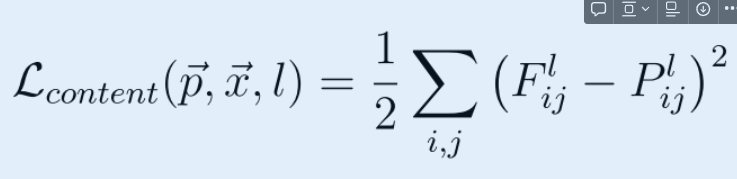

## Style Loss

By style, we basically mean to capture brush strokes and patterns. So we mainly use the lower layers, which capture low-level features.
The intuition behind using a gram matrix is that we’re trying to capture the statistics of the lower layers.

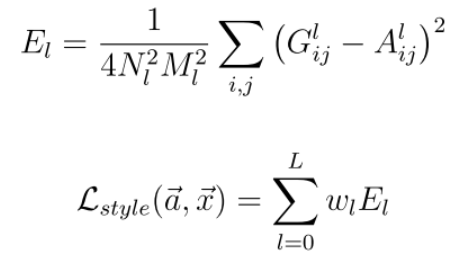

## Total Loss
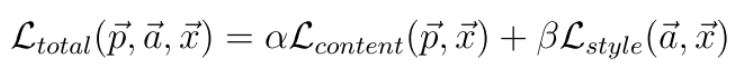

In [ ]:
class Loss(torch.nn.Module):
    def __init__(self, alpha=80, beta=15):
        super(Loss, self).__init__()
        self.alpha=alpha
        self.beta=beta

    def style_loss(self, gen_features, style_featues):
        batch_size, channel, height, width = gen_features.shape
        G=torch.mm(gen_features.view(channel, height*width), gen_features.view(channel, height*width).t())
        A=torch.mm(style_featues.view(channel, height*width), style_featues.view(channel, height*width).t())
        style_l=torch.mean(torch.pow((G - A), 2))
        return style_l

    def forward(self, gen_features, org_feautes, style_featues):
        style_loss = 0
        content_loss = 0
        # Calculate style loss
        for gen, style in zip(gen_features, style_featues):
            style_loss += self.style_loss(gen, style)

        content_loss = torch.mean(torch.pow((gen_features[-1] - org_feautes[-1]), 2)) * 0.5 
        total_loss= self.alpha*content_loss + self.beta*style_loss 
        return total_loss



# Train
Trainer class Does the main part of code which is training model, plot the training process and save model each n epochs.

I Defined `Adam` Optimizer with learning rate 0.0002.

Each generative model training step occurse in `train_generator` function, descriminator model training step in `train_descriminator` and whole trining process in 
`train` function.

## Some Configurations
 
*   You can set epoch size : `EPOCHS` and batch size : `BATCH_SIZE`.
*   Set `device` that you want to train model on it : `device`(default runs on cuda if it's available)
*   You can set one of three `verboses` that prints info you want => 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters size.
*   Each time you train model weights and plot(if `save_plots` == True) will be saved in `save_dir`.
*   You can find a `configs` file in `save_dir` that contains some information about run. 
*   You can choose Optimizer: `OPTIMIZER` 

In [ ]:
#@title Some Configurations
EPOCHS = 1000 #@param {type:"integer"}
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 3 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "./runs" #@param
MODEL_NAME = "MNIST cDCGAN Implementation" #@param
OPTIMIZER = "Adam" #@param ["Adam", "SGD"] {type:"raw"}


In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=DEVICE, epochs=EPOCHS, save_dir=SAVE_DIR, original_image=original_image, style_image=style_image, generated_image=generated_image, weights=None, verbose=VERBOSE, visualize_plots=VISUALIZE_PLOTS, save_plots=SAVE_PLOTS):
        self.device = device
        self.save_dir = save_dir
        self.epochs = epochs
        self.use_ema = False
        self.model_name = "Style Transfer using VGG"
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.train_losses=[]
        self.val_losses=[]
        self.conf = {'Name' : self.model_name, 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data
        self.original_image, self.style_image = original_image, style_image
        self.generated_image = generated_image

        # get model 
        self.model = self.get_model()
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()
    

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = VGG().to(self.device).eval()

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    # Get Optimizer Link : https://pytorch.org/docs/stable/optim.html
    def get_optimizer(self, optimizer="Adam", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD([self.generated_image], lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam([self.generated_image], lr=lr0, betas=(momentum, 0.999))

        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, gen_features, org_features, style_features):
        criterion = Loss()
        loss = criterion(gen_features, org_features, style_features)
        return loss

    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    # Each Train Step
    def train_step(self):
        org_features = self.model(self.original_image)
        gen_features = self.model(self.generated_image)
        style_features = self.model(self.style_image)
        loss  = self.compute_loss(gen_features, org_features, style_features)
        
        # backward
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.cpu().detach().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch
                    # Training loop
                    self.train_loss = self.train_step()
                    print("Epoch : {}\t\tLoss : {}".format(self.epoch, self.train_loss))
                    self.train_losses.append(self.train_loss)
                    # PLot Losses
                    if self.epoch % 100 == 0:
                        self.plot_loss()
                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    if (self.epoch+1) % 100 == 0:
                        self.eval_and_save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=1
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*5, ROWS*5))

        # train_mean_size = self.max_stepnum/self.batch_size
        # print(self.train_losses)
        ax.plot(np.arange(len(self.train_losses)), np.array(self.train_losses), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax.set_title("Training Loss")
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()
    # -------------------------------------------------------save-------------------------------------------
    def eval_and_save(self):
        # create config object
        image = self.generated_image
        plt.imshow(torch.squeeze(image).permute(1, 2, 0).cpu().detach().numpy())
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()


Trainer().train()

